In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [1]:


# Define the file path for your Excel file

file_path = r"Enter File path here"




# Extract the data from the file 

df = pd.read_excel(file_path, 
                   sheet_name="Case_Study1", 
                   usecols="B:F", 
                   skiprows=4, 
                   nrows=691, 
                   header=None)


df.columns = ["SPX_Date", "SPX_Value", "Empty", "NDX_Date", "NDX_Value"]


df.drop(columns=["Empty"], inplace=True)

spx_data = df[["SPX_Date", "SPX_Value"]].dropna(subset=["SPX_Date"]).copy()


spx_data["SPX_Date"] = pd.to_datetime(spx_data["SPX_Date"])


ndx_data = df[["NDX_Date", "NDX_Value"]].dropna(subset=["NDX_Date"]).copy()


ndx_data["NDX_Date"] = pd.to_datetime(ndx_data["NDX_Date"])


print("SPX Data (first 5 rows):")
print(spx_data.head(), "\n")

print("NDX Data (first 5 rows):")
print(ndx_data.head())

NameError: name 'pd' is not defined

In [ ]:

# 1. Define the VarianceSwap Class


class VarianceSwap:
    def __init__(self, underlying, df, date_column, value_column, start_date, maturity, N_vega, K_vol):
        
        # Parameters:
        #   underlying   : Name of the underlying index (e.g., 'SPX', 'NDX').
        #   df           : DataFrame containing the price data.
        #   date_column  : Name of the date column in the DataFrame.
        #   value_column : Name of the price column in the DataFrame.
        #   start_date   : Start date of the swap period (YYYY-MM-DD string).
        #   maturity     : Maturity date of the swap period (YYYY-MM-DD string).
        #   N_vega       : Vega notional (USD per volatility point).
        #   K_vol        : Strike volatility (in percentage points).
     
        self.underlying = underlying
        self.df = df
        self.date_column = date_column
        self.value_column = value_column
        self.start_date = pd.Timestamp(start_date)
        self.maturity = pd.Timestamp(maturity)
        self.N_vega = N_vega
        self.K_vol = K_vol
        

        self.num_days = None
        self.realized_variance = None
        self.variance_notional = None
        self.variance_strike = None
        self.payoff = None
        self.period_df = self.compute_period_df()
    
    def compute_period_df(self):
        #  this was computed separately in attempt to plot for the second trade without defining it separately 
        period_df = self.df[(self.df[self.date_column] >= self.start_date) & 
                            (self.df[self.date_column] <= self.maturity)].copy()
        period_df.sort_values(self.date_column, inplace=True)
        

        period_df['LogReturn'] = np.log(period_df[self.value_column] / period_df[self.value_column].shift(1))
        
        return period_df




    def compute_realized_variance(self):
        
        # Computes the annualized realized variance over the swap period.
        # Uses the formula:
        #     Realized Variance = (252 / N) * sum( (ln(S_i/S_(i-1)))^2 )
        # where N is the number of days in the periods given in the Case Study on Birghtspace
       
        # Filter data for the period [start_date, maturity] and sort by date
        period_df = self.df[(self.df[self.date_column] >= self.start_date) &
                            (self.df[self.date_column] <= self.maturity)].copy()
        period_df.sort_values(self.date_column, inplace=True)
        
        
        period_df['LogReturn'] = np.log(period_df[self.value_column] / period_df[self.value_column].shift(1))
        
        period_df.dropna(subset=['LogReturn'], inplace=True)
        
        self.num_days = len(period_df)
        self.realized_variance = (252 / self.num_days) * np.sum(period_df['LogReturn'] ** 2)
        return self.realized_variance

    def compute_swap_parameters(self):
       
        # Computes the variance swap parameters:
        #   Variance notional: N_var = N_vega / (2 * K_vol)
        #   Variance strike:  K_var = (K_vol)^2
        
        self.variance_notional = self.N_vega / (2 * self.K_vol)
        self.variance_strike = self.K_vol ** 2
        return self.variance_notional, self.variance_strike

    def compute_payoff(self):
      
        # Computes the swap payoff:
        #     Payoff = Variance Notional * (Realized Variance - Variance Strike)
        
        # this loop here is used to make sure the realized variance is computed 
        if self.realized_variance is None:
            self.compute_realized_variance()
        if self.variance_notional is None or self.variance_strike is None:
            self.compute_swap_parameters()
        self.payoff = self.variance_notional * (self.realized_variance - self.variance_strike)
        return self.payoff

    def summary(self):

        # Print summary function 
    
        # Ensure all metrics are computed
        if self.payoff is None:
            self.compute_payoff()
        summary_str = (
            f"Underlying: {self.underlying}\n"
            f"Trade Period: {self.start_date.date()} to {self.maturity.date()} (Days used: {self.num_days})\n"
            f"Realized Variance: {self.realized_variance:.4f}\n"
            f"Variance Notional: {self.variance_notional:.2f} USD per variance point\n"
            f"Variance Strike: {self.variance_strike:.4f}\n"
            f"Payoff: {self.payoff:.2f} USD\n"
        )
        return summary_str


# 2. Set Up Trade Parameters & Instantiate Classes


# SPX 
trade1 = VarianceSwap(
    underlying='SPX',
    df=spx_data,
    date_column='SPX_Date',
    value_column='SPX_Value',
    start_date='2016-03-02',
    maturity='2016-09-16',
    N_vega=100000,   # USD
    K_vol=0.2185     # 21.85%
)
#  NDX 
trade2 = VarianceSwap(
    underlying='NDX',
    df=ndx_data,
    date_column='NDX_Date',
    value_column='NDX_Value',
    start_date='2005-04-07',
    maturity='2005-12-16',
    N_vega=65000,    # USD
    K_vol=0.1965      # 19.65%
)




# 3. Compute and Display the Results


# # Raised error if path is wrong
# if file_path == r"":
#     raise ValueError("Please change the file path in the script (the cell above) before running.")




print("=== Trade 1 (SPX) ===")
print(trade1.summary())

print("=== Trade 2 (NDX) ===")
print(trade2.summary())


=== Trade 1 (SPX) ===
Underlying: SPX
Trade Period: 2016-03-02 to 2016-09-16 (Days used: 138)
Realized Variance: 0.0134
Variance Notional: 228832.95 USD per variance point
Variance Strike: 0.0477
Payoff: -7853.78 USD

=== Trade 2 (NDX) ===
Underlying: NDX
Trade Period: 2005-04-07 to 2005-12-16 (Days used: 177)
Realized Variance: 0.0179
Variance Notional: 165394.40 USD per variance point
Variance Strike: 0.0386
Payoff: -3423.08 USD



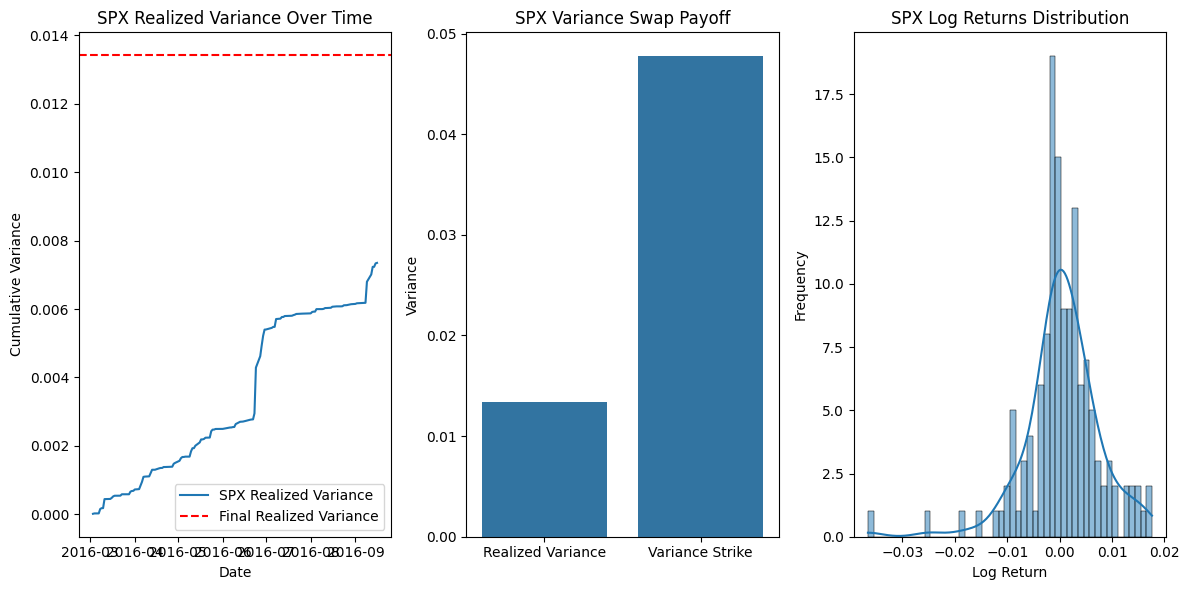

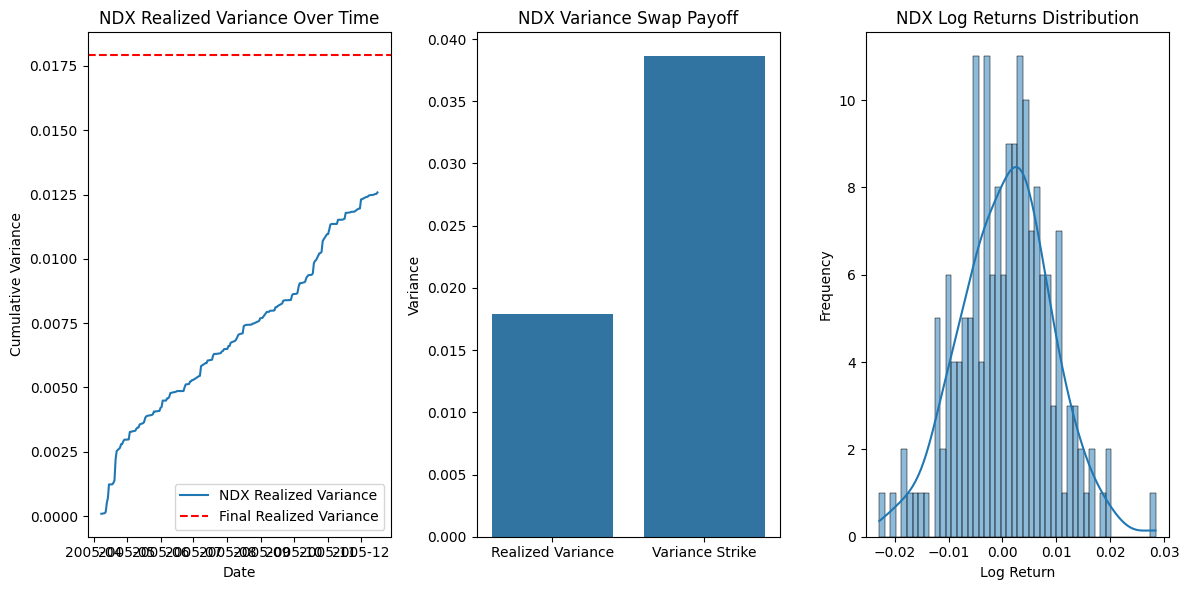

In [ ]:
def plot_variance_swap(period_df, date_column, realized_variance, variance_strike, underlying):
    plt.figure(figsize=(12, 6))
    
    # 1. Realized Variance Over Time
    period_df['CumulativeVariance'] = period_df['LogReturn'] ** 2
    period_df['CumulativeVariance'] = period_df['CumulativeVariance'].cumsum()
    
    plt.subplot(1, 3, 1)
    sns.lineplot(x=period_df[date_column], y=period_df['CumulativeVariance'], label=f'{underlying} Realized Variance')
    plt.axhline(y=realized_variance, color='r', linestyle='--', label='Final Realized Variance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Variance')
    plt.title(f'{underlying} Realized Variance Over Time')
    plt.legend()
    
    # 2. Payoff of the Variance Swap
    plt.subplot(1, 3, 2)
    sns.barplot(x=['Realized Variance', 'Variance Strike'], y=[realized_variance, variance_strike])
    plt.xlabel('')
    plt.ylabel('Variance')
    plt.title(f'{underlying} Variance Swap Payoff')
    
    # 3. Log Returns Distribution
 

# Example usage (assuming df_spx and df_ndx contain the necessary data)
plot_variance_swap(trade1.period_df,trade1.date_column, trade1.realized_variance, trade1.variance_strike, "SPX")
plot_variance_swap(trade2.period_df, trade2.date_column, trade2.realized_variance, trade2.variance_strike, "NDX")


